# Sharp Variables Analysis
This notebook is for the analysis of different variables related to solar flares and flux emergence.
1.	Why do some flaring active regions have rapid flux emergence before a flare and some don’t?
 - This is similar to the previous question of how does flux emergence relate to flaring, except now we are specifically looking at flaring regions, and trying to determine the factors that lead to flares.
 - Alternative version of the question: how do we know when a flaring active region will flare? Does it depend on flux emergence?
2.	Why do some rapid flux emergences flare and others don’t?
3.	Are there natural clusters of data given some physical variables?
 - Questions 1 and 2 will inform this question.
 - This question is an unsupervised learning problem.

In [29]:
import sys
import math
import random
import matplotlib.pyplot as plt
import scipy
import numpy as np

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier

# aas-timeseries
from aas_timeseries import InteractiveTimeSeriesFigure
from astropy import units
from astropy.timeseries import TimeSeries

# Bokeh plotting
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models.widgets import Button, RadioButtonGroup, Select, Slider
from bokeh.models import HoverTool
from bokeh.sampledata.glucose import data
from bokeh.io import output_notebook
from bokeh.layouts import column
output_notebook()

from notebook_import import NotebookFinder
sys.meta_path.append(NotebookFinder())
import flux_emergence_analysis as fea

Loading BokehJS ...

In [2]:
harp_ids, harp_noaa_dict = fea.get_harp_ids_and_harp_noaa_dict()
#flare_data = fea.get_flare_data(harp_ids, 'M1.0')
flare_data = fea.get_noaa_data_from_csv()
print('Number of active regions:', len(harp_ids))
print('Number of flares:', len(flare_data))

flare_time_dict = fea.get_harp_id_to_flaring_times_dict(harp_noaa_dict, flare_data)

Number of active regions: 1335
Number of flares: 8029


In [3]:
def get_segmented_data(harp_ids, flare_time_dict, n=None, return_harp_ids=False, num_hours=24):
    '''This method returns two arrays: x and y. The x array includes time series
    data, while y represents whether the corresponding active region in x flared.
    
    The x and y arrays are built according to the following rule:
        - If a flare occurs within num_hours hours after sample time t, it is considered
        to belong to the positive case (i.e. the corresponding y entry will be True).
        - If no flare occurs within num_hours hours, it is considered to belong to the
        negative case.
    
    The x array is an array of arrays, where each array represents a num_hours-hour set of
    data corresponding to an active region. Each of these num_hours-hour arrays are arrays of
    dictionaries representing the data at each recorded interval within the num_hours hours.
    
    The n parameter refers to how many negative data points. If n is set to None (default),
    then the number of negative data points = the number of positive data points.
    '''
    num_flares = 0
    for harp_id in harp_ids:
        keys = fea.read_data(harp_id)
        flare_data = flare_time_dict[harp_id]
        for flare_time in flare_data:
            if flare_time - keys.TIME[0] > num_hours and flare_time < keys.TIME.iloc[-1]:
                num_flares += 1
    if n != None:
        num_samples_per_datapoint = math.ceil(n / num_flares) * 10
    else:
        n = num_flares
        num_samples_per_datapoint = 10
    x = []
    y = []
    harp_list = []
    num_negative = 0
    for harp_id in harp_ids:
        keys = fea.read_data(harp_id)
        flare_data = flare_time_dict[harp_id]
        if flare_data:
            for flare_time in flare_data:
                # Throw out flare data with less than 24 hours of preceding data
                if flare_time - keys.TIME[0] > num_hours and flare_time < keys.TIME.iloc[-1]:
                    data = []
                    for i, time in enumerate(keys.TIME):
                        if time <= flare_time and time >= flare_time - num_hours:
                            data.append({'time': time, 'flux': keys.USFLUX[i],
                                        'free_energy': keys.TOTPOT[i], 'area': keys.AREA_ACR[i],
                                        'polarity_inversion_flux': keys.R_VALUE[i]})
                    if not data or data[-1]['time'] - data[0]['time'] < num_hours - 1:
                        # Insufficient data
                        continue
                    x.append(data)
                    harp_list.append(harp_id)
                    y.append(True) # True => flare is present
            for _ in range(num_samples_per_datapoint):
                if num_negative >= n: break
                first_time = keys.TIME[0]
                is_possible = False
                for flare_time in flare_data:
                    if flare_time - first_time > num_hours:
                        is_possible = True
                    first_time = flare_time
                if not is_possible: break
                is_valid = False
                while not is_valid:
                    end_time = keys.TIME[random.randrange(len(keys.TIME))]
                    for flare_time in flare_data + [keys.TIME[0]]:
                        if end_time - flare_time > num_hours: is_valid = True
                data = []
                for i, time in enumerate(keys.TIME):
                    if time <= end_time and time >= end_time - num_hours:
                        data.append({'time': time, 'flux': keys.USFLUX[i],
                                    'free_energy': keys.TOTPOT[i], 'area': keys.AREA_ACR[i],
                                    'polarity_inversion_flux': keys.R_VALUE[i]})
                if not data or data[-1]['time'] - data[0]['time'] < num_hours - 1:
                    # Insufficient data
                    continue
                x.append(data)
                harp_list.append(harp_id)
                y.append(False) # False => flare is not present
                num_negative += 1
    if return_harp_ids:
        return x, y, harp_list
    else:
        return x, y

In [4]:
seg_x, seg_y, harp_list = get_segmented_data(harp_ids, flare_time_dict,
                                             return_harp_ids=True, num_hours=24)
positive_count, negative_count = 0, 0
for has_flare in seg_y:
    if has_flare: positive_count += 1
    else: negative_count += 1
print('# Positive:', positive_count, '--- # Negative:', negative_count)

# Positive: 4552 --- # Negative: 4812


In [5]:
def plot_segmented_graphs(seg_x, seg_y, variables=['flux'], flare=True, n=5,
                          color=None, delta=True, scale=False):
    '''This method plots n random graphs that correspond to flaring active 
    regions if flare is True, and non-flaring active regions if flare is False.
    If delta is True, it normalizes the graph (variables at time=0 are set to 0).
    If scale is True, it normalizes the graph to be in the range [-1, 1].
    '''
    for _ in range(n):
        i = random.randrange(len(seg_y))
        while seg_y[i] != flare:
            i = random.randrange(len(seg_y))
        data = seg_x[i]
        for variable in variables:
            x, y = [], []
            start_data = data[0][variable]
            var_data = []
            for data_pt in data:
                var_data.append(data_pt[variable])
            if delta:
                max_data = max(max(var_data - start_data), abs(min(var_data - start_data))) / 1e22
            else:
                max_data = max(max(var_data), abs(min(var_data))) / 1e22
            for data_pt in data:
                x.append(data_pt['time'])
                y_pt = data_pt[variable] / 1e22
                if delta:
                    y_pt -= start_data / 1e22
                if scale:
                    y_pt /= max_data
                y.append(y_pt)
            variable_names = map(lambda x : x.title().replace('_', ' '), variables)
            fea.plot_graph(x, y, 'Hours Since Active Region Detected',
                        'Units',
                        ', '.join(variable_names) + ' vs. Time for Active Region',
                        clr=color, label=variable)
        plt.show()

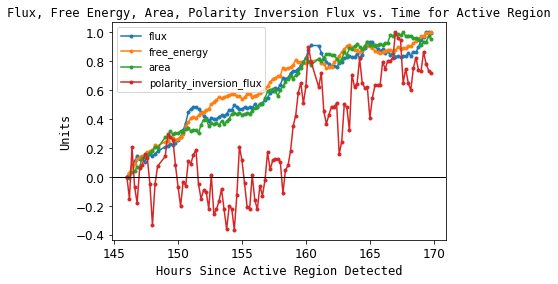

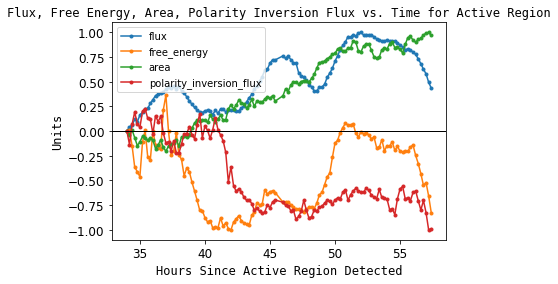

In [6]:
num_graphs = 2
plot_segmented_graphs(seg_x, seg_y, variables=['flux', 'free_energy', 'area',
                                               'polarity_inversion_flux'],
                      scale=True, flare=True, n=num_graphs)

## Spearman Coefficient
(from Wikipedia): Spearman's correlation assesses monotonic relationships (whether linear or not). If there are no repeated data values, a perfect Spearman correlation of +1 or −1 occurs when each of the variables is a perfect monotone function of the other.

In [6]:
def calculate_spearman(seg_x, first_var, second_var):
    '''Calculate the Spearman coefficient between two variables. This method calculates
    the coefficient between the two variables for every time series data series, then
    returns the mean and standard deviation of the coefficients.
    '''
    s_coeff_list = []
    for data in seg_x:
        first_var_data = []
        second_var_data = []
        for data_pt in data:
            first_var_data.append(data_pt[first_var])
            second_var_data.append(data_pt[second_var])
        s_coeff = scipy.stats.spearmanr(first_var_data, second_var_data).correlation
        if not math.isnan(s_coeff): s_coeff_list.append(s_coeff)
    return np.mean(s_coeff_list), np.std(s_coeff_list)

In [7]:
for var in ['free_energy', 'area', 'polarity_inversion_flux']:
    s_coeff, s_dev = calculate_spearman(seg_x, 'flux', var)
    print('S_coefficient for flux vs.', var + '. mean:', s_coeff, 'std:', s_dev)

S_coefficient for flux vs. free_energy. mean: 0.49442259048944953 std: 0.5222388088675852
S_coefficient for flux vs. area. mean: 0.1381914467117373 std: 0.6325912394849076


/Users/lucaspauker/anaconda3/envs/solar_physics/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/lucaspauker/anaconda3/envs/solar_physics/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/lucaspauker/anaconda3/envs/solar_physics/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/lucaspauker/anaconda3/envs/solar_physics/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/lucaspauker/anaconda3/envs/solar_physics/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


S_coefficient for flux vs. polarity_inversion_flux. mean: 0.16953346411120573 std: 0.46250670671533306


In [8]:
def create_learning_dataset(seg_x, seg_y, variable, features):
    '''Creates learning dataset with time series data.
    '''
    x, y = [], []
    for i, data in enumerate(seg_x):
        if len(data) < 4: continue
        time_data, variable_data = [], []
        for data_pt in data:
            time_data.append(data_pt['time'])
            if variable in ['flux', 'free_energy']:
                variable_data.append(data_pt[variable] / 1e22)
            else:
                variable_data.append(data_pt[variable])
        #print(seg_y[i])
        time_data = np.array(time_data)
        variable_data = np.array(variable_data)
        data, names = fea.extract_time_series_features(time_data, variable_data, features)
        if not any(data): continue
        x.append(data)
        y.append(seg_y[i])
    return x, y, names

In [9]:
features = [fea.quadratic_features]
raw_x_data = np.array([])
y_data = []
variables = ['flux', 'free_energy']
for variable in variables:
    x, y, feature_names = create_learning_dataset(seg_x, seg_y, variable, features)
    if raw_x_data.size == 0: raw_x_data = np.array(x)
    else: raw_x_data = np.hstack((raw_x_data, np.array(x)))
    y_data = y
print('Features used:', feature_names, 'for', ' and '.join(variables))

Features used: ['quad_1', 'quad_2', 'quad_3', 'r^2_quad'] for flux and free_energy


In [10]:
x_data = fea.scale_x_data(raw_x_data)
print(len(x_data), len(y_data))

9364 9364


In [11]:
print(x_data)

[[0.6948716  0.1860755  0.77690459 ... 0.30348944 0.69408871 0.97087608]
 [0.61960701 0.20105196 0.77459941 ... 0.3108135  0.69285327 0.98943417]
 [0.63524634 0.1972363  0.77531708 ... 0.30990955 0.69302968 0.98895076]
 ...
 [0.6250418  0.19978853 0.7750598  ... 0.31302903 0.6928075  0.83680842]
 [0.64799078 0.19165724 0.77719481 ... 0.30030842 0.69724803 0.97106653]
 [0.64696071 0.1932702  0.7758784  ... 0.29871033 0.7007736  0.94488703]]


In [12]:
fea.run_learning_algorithms(x_data, y_data)

Stochastic Gradient Descent:
> Train accuracy: 0.5212729602733873
> Test accuracy: 0.5192140111063648
> Precision: 0.5473624503686897
> Recall: 0.4239894551845343
> TSS Score: 0.09231863224189091
> [[ 0.91715747  0.46037734  1.39537908  0.42946988 -1.05937894  3.60477005
   1.08340584  1.19969972]] 

AdaBoost:
> Train accuracy: 0.692140111063648
> Test accuracy: 0.6802221272960273
> Precision: 0.7074311023622047
> Recall: 0.6315905096660809
> TSS Score: 0.3844999028497883
> [0.04 0.12 0.16 0.   0.2  0.28 0.12 0.08] 

{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 25, 'random_state': 0}
Random Forest:
> Train accuracy: 0.6680506905880677
> Test accuracy: 0.6611191798376762
> Precision: 0.7001693958215698
> Recall: 0.5448154657293497
> TSS Score: 0.32411721136525995
> [0.05063921 0.06102634 0.07384033 0.00279013 0.32426945 0.24275891
 0.1970389  0.04763673] 

The best algorithm is AdaBoost with a test accuracy of 0.6802221272960273


# Data Analysis
Let's understand the relationship between accuracy and lag time, as well as accuracy vs. prediction time.

In [13]:
def lag_vs_accuracy_graph(harp_ids, flare_time_dict, hour_range=range(1, 25, 5)):
    #seg_x, seg_y, harp_list = get_segmented_data(harp_ids, flare_time_dict,
    #                                             return_harp_ids=True, num_hours=hour_range[-1])
    time_data = []
    accuracy_data = []
    data_dict = {}
    variables = ['flux', 'free_energy']
    for variable in variables: data_dict[variable] = [] # List of (time, accuracy, error)
    for lag in hour_range:
        time_data.append(lag)
        modified_seg_x = []
        # Take time off of the start
        for data in seg_x:
            end_time = data[-1]['time']
            for i, point in enumerate(data):
                if end_time - point['time'] < lag:
                    modified_seg_x.append(data[i:])
                    break
        print('Time:', modified_seg_x[0][-1]['time'] - modified_seg_x[0][0]['time'])
        lag_time = modified_seg_x[0][-1]['time'] - modified_seg_x[0][0]['time']
        features = [fea.spline_features]
        raw_x_data = np.array([])
        y_data = []
        for variable in variables:
            print(variable)
            x, y, feature_names = create_learning_dataset(modified_seg_x, seg_y, variable, features)
            raw_x_data = np.array(x)
            x_data = fea.scale_x_data(raw_x_data)
            y_data = y

            #clf = AdaBoostClassifier(n_estimators=25, random_state=0)
            clf = SGDClassifier(loss='hinge', penalty='l2')
            accuracies = []
            for _ in range(10):
                _, test_accuracy = fea.fit_algorithm(clf, x_data, y_data, 50)
                accuracies.append(test_accuracy)
            accuracy = np.mean(accuracies)
            accuracy_error = np.std(accuracies)
            data_dict[variable].append((lag_time, accuracy, accuracy_error))
            result_vals_dict = {'TP': 0, 'FP': 0, 'TN': 0, 'FN':0}
            for i, data_pt in enumerate(x):
                prediction = clf.predict([data_pt])
                if prediction == y[i]:
                    if prediction == 1:
                        result_vals_dict['TP'] += 1
                    else:
                        result_vals_dict['TN'] += 1
                else:
                    if prediction == 1:
                        result_vals_dict['FP'] += 1
                    else:
                        result_vals_dict['FN'] += 1
            precision = result_vals_dict['TP'] / (result_vals_dict['TP'] + result_vals_dict['FP'])
            recall = result_vals_dict['TP'] / (result_vals_dict['TP'] + result_vals_dict['FN'])
            f1 = 2 * (precision * recall) / (precision + recall)

            print('Accuracy:', accuracy)
            print('Accuracy error:', accuracy_error)
            print('F1:', f1)
            print()
    return data_dict

In [14]:
data_dict = lag_vs_accuracy_graph(harp_ids, flare_time_dict)

Time: 0.7999999999999972
flux
Accuracy: 0.6545414364640884
Accuracy error: 0.013968459240208796
F1: 0.599502487562189

free_energy
Accuracy: 0.6501325966850829
Accuracy error: 0.007716481844771169
F1: 0.59447983014862

Time: 5.799999999999997
flux
Accuracy: 0.6970989293361884
Accuracy error: 0.0019316096945993975
F1: 0.6738271052435295

free_energy
Accuracy: 0.6915083511777304
Accuracy error: 0.0013162527531243307
F1: 0.6564288301340094

Time: 10.799999999999997
flux
Accuracy: 0.6987205128205127
Accuracy error: 0.00224935133221457
F1: 0.6665198884485543

free_energy
Accuracy: 0.693079487179487
Accuracy error: 0.0009512021836984765
F1: 0.6572647718232444

Time: 15.799999999999997
flux
Accuracy: 0.6982229816317813
Accuracy error: 0.0022594556162283696
F1: 0.6640362414145843

free_energy
Accuracy: 0.6932960273387442
Accuracy error: 0.0021763674710482362
F1: 0.6582168465271239

Time: 20.999999999999996
flux
Accuracy: 0.6990636480136694
Accuracy error: 0.002146125423837515
F1: 0.66647101980

In [15]:
data_dict

{'flux': [(0.7999999999999972, 0.6545414364640884, 0.013968459240208796),
  (5.799999999999997, 0.6970989293361884, 0.0019316096945993975),
  (10.799999999999997, 0.6987205128205127, 0.00224935133221457),
  (15.799999999999997, 0.6982229816317813, 0.0022594556162283696),
  (20.999999999999996, 0.6990636480136694, 0.002146125423837515)],
 'free_energy': [(0.7999999999999972,
   0.6501325966850829,
   0.007716481844771169),
  (5.799999999999997, 0.6915083511777304, 0.0013162527531243307),
  (10.799999999999997, 0.693079487179487, 0.0009512021836984765),
  (15.799999999999997, 0.6932960273387442, 0.0021763674710482362),
  (20.999999999999996, 0.6943212302434857, 0.0016114731374412298)]}

In [27]:
fig = InteractiveTimeSeriesFigure(title='Radial Velocity Curve', time_mode='relative')
fig.xlabel = 'Lag time (hours)'
fig.ylabel = 'Percent accuracy'
for var in data_dict:
    time_data = []
    accuracy_data = []
    error_data = []
    for tup in data_dict[var]:
        time_data.append(tup[0])
        accuracy_data.append(tup[1])
        error_data.append(tup[2])
    ts = TimeSeries(time_start='2016-03-22T12:30:31', time_delta=3*units.s, n_samples=len(time_data))
    ts['relative'] = time_data * units.s
    ts['accuracy'] = accuracy_data
    markers = fig.add_line(time_series=ts, time_column='relative', column='accuracy', size=50, label='Test')
    markers.tooltip = ['accuracy']
    #fea.plot_graph(time_data, accuracy_data, 'Lag time (hours)', 'Accuracy (%)', 'Lag time vs. accuracy')
fig.preview_interactive()

TimeSeriesWidget(vega_json='{\n  "$schema": "https://vega.github.io/schema/vega/v4.json",\n  "_extend": {\n   …

In [54]:
accuracy_data = {}
error_data = {}
for var in data_dict:
    time_data = []
    accuracy_subset = []
    error_subset = []
    for tup in data_dict[var]:
        time_data.append(tup[0])
        accuracy_subset.append(tup[1])
        error_subset.append(tup[2])
    accuracy_data[var] = accuracy_subset
    error_data[var] = error_subset

# Basic plot setup
plot = figure(plot_width=600, plot_height=300, tools="",
              toolbar_location=None, title="Lag time vs. accuracy",
              x_axis_label='x', y_axis_label='y')

cr = []
colors = ["orange", "green", "purple"]
for i, var in enumerate(accuracy_data):
    source = ColumnDataSource(data=dict(
        x_data = time_data,
        y_data = accuracy_data[var],
    ))
    plot.line("x_data", "y_data", line_width=1, color=colors[i],
              legend=var.capitalize().replace("_", " "), source=source)
    cr.append(plot.circle("x_data", "y_data", size=10, source=source,
                    fill_color="grey", hover_fill_color=colors[i],
                    fill_alpha=0.05, hover_alpha=0.5,
                    line_color=None, hover_line_color="white"))

plot.add_tools(HoverTool(tooltips=[("flux", "@y_data")], renderers=cr, mode='vline'))
plot.legend.location = "bottom_right"

show(column(plot))